# 1. Configurations

## 1.1 Install Packages

In [ ]:
!pip install transformers==4.30.2 loralib==0.1.1 sentencepiece==0.1.99 livelossplot==0.5.5
!python -m spacy download en_core_web_sm

## 1.2 Mount

In [ ]:
from google.colab import drive
drive.mount('/mnt')

!ln -s /mnt/MyDrive/court-decision-prediction /root
!cp /mnt/MyDrive/modeling_llama.py /usr/local/lib/python3.10/dist-packages/transformers/models/llama/modeling_llama.py

Modify file for lora: `/usr/local/lib/python3.10/dist-packages/transformers/models/llama/modeling_llama.py`

https://github.com/microsoft/LoRA#quickstart
```
# ===== Before =====
# layer = nn.Linear(in_features, out_features)

# ===== After ======
import loralib as lora
# Add a pair of low-rank adaptation matrices with rank r=16
layer = lora.Linear(in_features, out_features, r=16)
```

## 1.3 Import Packages

In [ ]:
import os
from os.path import join, dirname
import random
import warnings

import numpy as np
import pandas as pd
import spacy
from tqdm import tqdm, trange

import torch
from torch import nn

import loralib as lora

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import NeighbourhoodCleaningRule

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")

## 1.4 Random Seed

In [ ]:
def seed_everything(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

## 1.5 PATH

In [ ]:
class PATH:
    root   = '/root/court-decision-prediction'
    yaml   = join(root, 'court_decision_prediction/configs.yaml')
    data   = join(root, 'data/open')
    train  = join(data, 'train.csv')
    test   = join(data, 'test.csv')
    sample = join(data, 'sample_submission.csv')
    submit = join(root, 'submission')
    models = join(root, 'models')

os.makedirs(PATH.models, exist_ok=True)

# 2. Load Dataset

## 2.1 Load Raw Data

In [ ]:
train_full_data = pd.read_csv(PATH.train)
test_data       = pd.read_csv(PATH.test)
target          = 'first_party_winner'

# 3. EDA

In [ ]:
data = train_full_data.copy()

## 3.1 `first_party`, `second_party`

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


def preprocess(data, target):
    data = append_party_group(data)
    # if target in data:
        # data = undersampling(data, target)
        # data.reset_index(drop=True, inplace=True)
    return data

def append_party_group(data):
    data = data.copy()

    def generate_fn(col):
        len_filter = lambda fn, arr: len(list(filter(fn, arr)))  # get number of elements in arr filtered by fn

        def fn(row):
            party       = row[col]
            party_lower = row[col].lower()

            keywords_usa = ['united states', 'national']
            keywords_gpe = ['city', 'republic', 'region', 'district', 'county']
            keywords_org = ['corporation', 'inc', 'company', 'bank', 'association', 'llc', 'ltd', 'llp', 'co.', 'hospital', 'usa', 'school', 'group', 'office', 'department', 'commision']
            keywords_grp = [',', 'et al']

            for keyword in keywords_usa:
                if keyword in party_lower:
                    return 'USA'
            else:
                ents = nlp(party).ents
                labels = [e.label_ for e in ents]
                if ('GPE' in labels) or len_filter(lambda k: k in party_lower, keywords_gpe):
                    return 'GPE'
                elif ('ORG' in labels) or ('NORP' in labels) or len_filter(lambda k: k in party_lower, keywords_org):
                    return 'ORG'
                elif (len(labels) > 1) or len_filter(lambda k: k in party_lower, keywords_grp):
                    return 'GRP'
                else:
                    return 'IND'

        return fn


    data['first_party_grp']  = data.apply(generate_fn('first_party'), axis=1)
    data['second_party_grp'] = data.apply(generate_fn('second_party'), axis=1)
    return data

def undersampling(data, target):
    data_zero_target = data[data[target] == 0]
    data_one_target  = data[data[target] == 1]
    first_party_grp_int = LabelEncoder().fit_transform(data_one_target['first_party_grp'])
    data_one_target_sample = resample(data_one_target, replace=False, n_samples=len(data_zero_target), stratify=first_party_grp_int)
    data = pd.concat([data_zero_target, data_one_target_sample])
    return data

# data_pp = preprocess(data, target)
# data_pp.head()

In [ ]:
# _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
# data[target].plot.hist(ax=ax1),    ax1.set_title(f"{target} (before undersampling)")
# data_pp[target].plot.hist(ax=ax2), ax2.set_title(f"{target} (after undersampling)");

In [ ]:
# def plot_party(ax1, ax2, f):
#     data_pp[f].value_counts().head(10).plot.bar(ax=ax1),        ax1.set_title(f"{f} (# unique: {data_pp[f].nunique()})")
#     data_pp[f'{f}_grp'].value_counts().plot.bar(ax=ax2, rot=0), ax2.set_title(f"{f}_grp (# unique: {data_pp[f+'_grp'].nunique()})")

# for f in ('first_party', 'second_party'):
#     fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
#     plot_party(ax1, ax2, f)

In [ ]:
# for party in ('first_party', 'second_party'):
#     party_grp = f"{party}_grp"
#     for val in data_pp[party_grp].unique():
#         sample = data_pp[data_pp[party_grp] == val].sample(5)
#         print(party, val, ':', sample[party].tolist())

In [ ]:
# median = np.median((conf-0.5).values.flatten())
# median_abs = np.median((conf-0.5).abs().values.flatten())


# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 10))

# sns.histplot((conf-0.5).values.flatten(), ax=ax1)
# ax1.axvline(median, color='k', label=f'Median={median:.3f}')
# ax1.set_title("Histogram for Mean(target)-0.5")
# ax1.legend();

# sns.histplot((conf-0.5).abs().values.flatten(), ax=ax2)
# ax2.axvline(median_abs, color='k', label=f'Median={median_abs:.3f}')
# ax2.set_title("Histogram for abs(Mean(target)-0.5)")
# ax2.legend();

In [ ]:
# conf = data_pp.pivot_table(index='first_party_grp', columns='second_party_grp', values=target)

# _, ax = plt.subplots(figsize=(8, 7))
# sns.heatmap(conf-0.5, annot=True, center=0, cmap='coolwarm', ax=ax)
# ax.set_title("Mean(target)-0.5 for first_party_grp vs second_party_grp");

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(n_estimators=500)
# X = pd.get_dummies(data_pp[['first_party_grp', 'second_party_grp']])
# y = data_pp[target]
# model.fit(X, y)

# fi_mean = pd.Series(model.feature_importances_, index=X.columns, name='Feature Importances')
# fi_std  = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
# fi_mean.plot.bar(yerr=fi_std, title='Feature Importances using MDI', ylabel='Mean decrease in impurity');

## 3.2 `facts`

In [ ]:
def select_facts(data):
    transition_words = ["accordingly", "additionally", "also", "although", "alternatively", "as a result", "besides", "but", "consequently", "conversely", "despite", "due to", "either", "equally", "eventually", "finally", "first", "furthermore", "hence", "however", "in addition", "in conclusion", "in contrast", "in other words", "in spite of", "instead", "likewise", "meanwhile", "moreover", "nevertheless", "next", "nonetheless", "nor", "on the contrary", "on the other hand", "otherwise", "overall", "particularly", "similarly", "since", "so", "subsequently", "that is", "then", "therefore", "though", "thus", "ultimately", "unless", "unlike", "until", "when", "whereas", "while", "yet", "above all", "afterward", "all in all", "as an illustration", "as well as", "at the same time", "at length", "basically", "certainly", "comparatively", "consequently", "eventually", "for example", "for instance", "for this reason", "for the most part", "for this purpose", "generally", "given these points", "in a word", "in any case", "in essence", "in fact", "in general", "in particular", "in reality", "in short", "in summary", "in the first place", "notably", "of course", "of great importance", "of necessity", "of course", "of great importance", "of necessity", "specifically", "surprisingly", "to begin with", "to conclude", "to illustrate", "to sum up", "to summarize", "truly", "without a doubt"]
    core_words       = ['court', 'reverse', 'judge', 'adjudicate', 'guilty']

    data = data.reset_index(drop=True)
    for doc_id, doc in enumerate(tqdm(data.facts)):
        row = data.iloc[doc_id]
        first_party, second_party = row['first_party'], row['second_party']
        selected_sents = []
        for sent in nlp(doc).sents:
            sent_str = sent.text
            cond1 = any(sent_str.lower().startswith(word) for word in transition_words)
            cond2 = any(word in sent.lemma_.lower() for word in core_words)
            cond3 = (first_party in sent_str.lower()) or (second_party in sent_str.lower())
            is_selected = True if any([cond1, cond2, cond3]) else False
            if is_selected:
                selected_sents.append(sent_str)
        else:
            # always add last sentence
            if not is_selected:
                selected_sents.append(sent_str)
        data.loc[doc_id, 'facts'] = '\n'.join(selected_sents)
    return data

# data_pp2 = select_facts(data_pp)

In [ ]:
# for idx_row in range(5):
#     first_party  = data_pp.first_party[idx_row]
#     second_party = data_pp.second_party[idx_row]
#     first_party_winner = data_pp[target][idx_row]
#     fact_before  = data_pp.facts[idx_row]
#     fact_after   = data_pp2.facts[idx_row]
#     print(first_party, 'vs', second_party, ':', first_party_winner)
#     print("- Before\n" + fact_before)
#     print("- After\n" + fact_after)
#     print(100*"-")

In [ ]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
# sns.histplot(data_pp.facts.str.len(), stat='probability',  ax=ax1), ax1.set_title('facts length distribution (before selected)')
# sns.histplot(data_pp2.facts.str.len(), stat='probability', ax=ax2), ax2.set_title('facts length distribution (after selected)')
# plt.show()

# print(data_pp.facts.str.len().mean(), data_pp2.facts.str.len().mean())

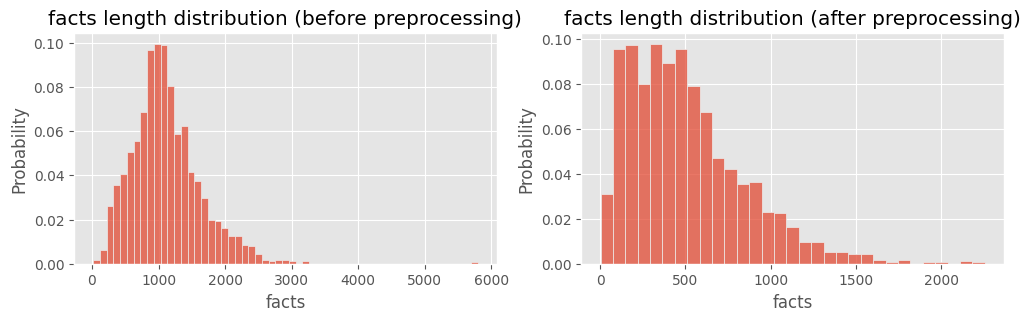

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer

# model_id  = "lmsys/vicuna-13b-v1.3"
model_id  = "lmsys/vicuna-7b-v1.3"

model     = LlamaForCausalLM.from_pretrained(model_id).to(torch.bfloat16)
tokenizer = LlamaTokenizer.from_pretrained(model_id)

In [ ]:
# def get_answer(prompt):
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
#     L = len(input_ids[0])
#     with torch.no_grad():
#         outputs_gen = model.generate(input_ids=input_ids, max_new_tokens=1)[0, L:]  # [B, 1, L+max_new_tokens] -> [max_new_tokens]
#         outputs     = model(input_ids=input_ids).logits.argmax(dim=2)[0, [-1]]      # [B, L]                   -> [1]
#     print(tokenizer.decode(outputs_gen), outputs_gen)
#     print(tokenizer.decode(outputs), outputs)

In [ ]:
# prompt = f"""Question: What is 1+1?
# Answer: """
# get_answer(prompt)

In [ ]:
# tokenizer('0')

In [ ]:
# tokenizer.decode(1), tokenizer.decode(29871), tokenizer.decode(29900)

In [ ]:
# tokenizer('1')

In [ ]:
# tokenizer.decode(1), tokenizer.decode(29871), tokenizer.decode(29896)

In [ ]:
# def get_prompt(row):
#     return f"""USER:
# - first_party: {row['first_party']}
# - second_party: {row['second_party']}
# - facts:
# {row['facts'][-1000:]:1000}
# - Question: Do the first_party win the case? Answer with only 1 or 0. DO NOT ANSWER ANY OTHER WORDS.

# ASSISTANT:
# - Answer: """

# sample = train_full_data.sample(1).squeeze()
# get_answer(get_prompt(sample))
# print(sample[target])

```
USER:
    - first_party: Maryland
    - second_party: Michael Blaine Shatzer, Sr.
    - facts:
    In August 2003, a detective from the Hagerstown, MD Police Department interviewed Michael Blain Shatzer Sr. regarding allegations that he had sexually abused his three-year old child. At the time, Mr. Shatzer was incarcerated on an unrelated offense involving sexual abuse of another child. After Mr. Shatzer invoked his Fifth Amendment rights to counsel and to remain silent, the interview was terminated. The investigation was subsequently closed, only to be reopened in January 2006 on the prompting of Mr. Shatzer's wife, when she recognized her child could make more specific allegations about Mr. Shatzer's alleged sexual abuse. Thereafter in March 2006, another detective from the Hagerstown Police Department, who was aware that Mr. Shatzer had been under investigation, but was not aware that Mr. Shatzer had previously invoked his Fifth Amendment rights to counsel and to remain silent, interviewed him. At this interview, Mr. Shatzer was advised of his Fifth Amendment rights, which he waived, and then confessed to specific instances of sexual abuse involving his child.
Prior to trial, Mr. Shatzer moved to suppress the confessions he made in the March 2006 interview arguing that his 2003 invocation of his Fifth Amendment rights was still applicable. Under Edwards v. Arizona rendered the confession inadmissible. The motion was denied and a Maryland trial court convicted him of sexual child abuse. On appeal, the Court of Appeals of Maryland reversed, holding that the protections of Edwards applies for an inmate who has been continually incarcerated and had previously invoked his Fifth Amendment rights, until either counsel is made available or the inmate initiates further conversation with police. Therefore, under the circumstances, Mr. Shatzer's confession was inadmissible.

    - Question: I want to know whether first_party win case, and detailed reasons.

    ASSISTANT:
    - Answer:

In this case, the first party, Michael Blaine Shatzer, Sr., was accused of sexual abuse of his three-year-old child. During an initial interview in August 2003, Mr. Shatzer invoked his Fifth Amendment rights and the interview was terminated
1
```

```
USER:
    - first_party: Cole (group: IND)
    - second_party: Young (group: IND)
    - facts:
    Mr. Cole brought an action seeking declaratory judgment in the District of Columbia federal district court alleging that his discharge was invalid and that the Civil Service Commission improperly denied his appeal.
The district court dismissed the case and the U.S. Court of Appeals for the District of Columbia affirmed.

    - Question: I want to know whether first_party win case, and detailed reasons.

    ASSISTANT:
    - Answer:
    No, Mr. Cole did not win the case. The district court and the U.S. Court of Appeals for the District of Columbia both dismissed his case. The courts ruled that the Civil Service Commission had the authority to discharge Mr. Cole and that his discharge was not invalid.
1
```

# 4. Modeling

In [ ]:
# Lora setting
model.requires_grad = False
lora.mark_only_lora_as_trainable(model)

# Change trainable head
model.lm_head = nn.Linear(4096, 2)
model.lm_head.requires_grad = True
model = model.to(torch.bfloat16).cuda()

In [ ]:
model

## 4.1 Generate Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# def get_prompt(row):
#     return f"""USER:
# - first_party: {row['first_party']} ({row['first_party_grp']})
# - second_party: {row['second_party']} ({row['second_party_grp']})
# - facts:
# {row['facts'][-1000:]:1000}
# - Question: Do the first_party win the case? Answer with only 1 or 0. DO NOT ANSWER ANY OTHER WORDS.

# ASSISTANT:
# - Answer: """

def get_prompt1(row):
    return f"""USER:
- first_party: {row['first_party']} ({row['first_party_grp']})
- second_party: {row['second_party']} ({row['second_party_grp']})
- facts:
{row['facts'][-1000:]:1000}"""

def get_prompt2():
    return """
- Question: Do the first_party win the case? Answer with only 1 or 0. DO NOT ANSWER ANY OTHER WORDS.

ASSISTANT:
- Answer: """


class CustomDataset(Dataset):
    def __init__(self, data, target, tokenizer):
        self.data      = data
        self.target    = target
        tokenizer.pad_token = tokenizer.eos_token
        self.input_ids = self._get_input_ids(data, tokenizer)
        self.labels    = self._get_labels(data)

    def _get_input_ids(self, data, tokenzier):
        prompts = []
        for idx_row in range(len(data)):
            row = self.data.iloc[idx_row]
            prompt = get_prompt1(row)
            prompts.append(prompt)
        prompt1 = tokenizer(prompts, return_tensors='pt', padding='longest').input_ids
        prompt2 = tokenizer(get_prompt2(), return_tensors='pt').input_ids.expand(len(prompt1), -1)
        input_ids = torch.cat([prompt1, prompt2], dim=1)
        return input_ids.cuda()

    def _get_labels(self, data):
        labels = []
        for idx_row in range(len(data)):
            row = data.iloc[idx_row]
            label = row[self.target] if self.target in data else -1  # -1: dummy
            labels.append(label)
        return torch.tensor(labels, dtype=torch.bfloat16).cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.input_ids[idx]
        label = self.labels[idx]
        return input, label

In [ ]:
train_full_data_pp = undersampling(select_facts(preprocess(train_full_data, target)), target)
test_data_pp       = select_facts(preprocess(test_data, target))

train_data_pp, val_data_pp = train_test_split(train_full_data_pp, test_size=0.25, stratify=train_full_data_pp[target])

train_ds = CustomDataset(train_data_pp, target, tokenizer)
val_ds   = CustomDataset(val_data_pp,   target, tokenizer)
test_ds  = CustomDataset(test_data_pp,  target, tokenizer)

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=1)
test_dl  = DataLoader(test_ds,  batch_size=1)

In [ ]:
# def get_prompt(row):
#     return f"""USER:
# - first_party: {row['first_party']} ({row['first_party_grp']})
# - second_party: {row['second_party']} ({row['second_party_grp']})
# - facts:
# {row['facts']}
# - Question: Do the first_party win the case? Answer with 1 or 0, without any other words.

# ASSISTANT:
# - Answer: """

# sample = train_data_pp.sample(1).squeeze()
# get_answer(get_prompt(sample))
# print(sample[target])

## 4.2 Modeling

In [ ]:
# zero_logit = output[:, -1, 29900]  # [B]
# one_logit  = output[:, -1, 29896]  # [B]
# logits     = output[:, -1, [29900, 29896]]  # [B, 2]
# softmax    = F.softmax(logits)     # [B, 2]
# loss       = -(y*torch.log(softmax[:, 1]) + (1-y)*torch.log(softmax[:, 0]))
# logit      = F.softmax(logits)[0][1]
# acc        = 1 if ((zero_logit[0] > one_logit[0]) and y[0] == 0) or ((zero_logit[0] < one_logit[0]) and y[0] == 1) else 0

# token = output[0, -1].argmax()
# token_dec = tokenizer.decode(token)
# print(token_dec, token)

In [ ]:
# output_gen = model.generate(X)

In [ ]:
from livelossplot import PlotLosses
import torch.nn.functional as F


to_cpu = lambda arr: arr.detach().float().cpu().numpy()

def plot_logits_labels(logits, labels, val_logits, val_labels, epoch):
    fig, axes = plt.subplots(ncols=2, figsize=(20, 8))

    logits_last_epoch = logits[-1160:]
    labels_last_epoch = labels[-1160:]

    val_logits_last_epoch = val_logits[-498:]
    val_labels_last_epoch = val_labels[-498:]

    for ax, id, y_, y in zip(axes, ['train', 'val'], [logits_last_epoch, val_logits_last_epoch], [labels_last_epoch, val_labels_last_epoch]):
        df_preds = pd.DataFrame({'pred': y_, 'target': y})
        df0      = df_preds[df_preds['target'] == 0]['pred']
        df1      = df_preds[df_preds['target'] == 1]['pred']
        sns.kdeplot(df0, color='blue',   label='target=0', ax=ax)
        sns.kdeplot(df1, color='orange', label='target=1', ax=ax)
        ax.axvline(0.5, color='k')
        ax.legend(), ax.grid()
        ax.set_title(f"Logit Distribution ({id})")
    fig.tight_layout()
    fig.savefig(f"Logit Distribution-epoch={epoch}.png")
    plt.show()
    plt.close(fig)

def compute_loss_acc(X, y):
    output     = model(X).logits              # B, S, D = output.logits.shape
    # zero_logit = output[:, -1, 29900]  # [B]
    # one_logit  = output[:, -1, 29896]  # [B]
    # logits     = output[:, -1, [29900, 29896]]  # [B, 2]
    zero_logit = output[:, -1, 0]  # [B]
    one_logit  = output[:, -1, 1]  # [B]
    logits     = output[:, -1, [0, 1]]  # [B, 2]
    softmax    = F.softmax(logits)     # [B, 2]
    loss       = -(y*torch.log(softmax[:, 1]) + (1-y)*torch.log(softmax[:, 0]))
    logit      = F.softmax(logits)[0][1]
    acc        = 1 if ((zero_logit[0] > one_logit[0]) and y[0] == 0) or ((zero_logit[0] < one_logit[0]) and y[0] == 1) else 0

    # token = output[0, -1].argmax()
    # token_dec = tokenizer.decode(token)
    # print(token_dec, token)
    # preds = output[0, -1]
    # print(f"target: {y} | pred: {softmax}")
    return logit.item(), y[0].item(), loss, acc

def train_step(X, y):
    logit, label, loss, acc = compute_loss_acc(X, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return logit, label, loss.item(), acc

def val_step(X, y):
    logit, label, loss, acc = compute_loss_acc(X, y)
    return logit, label, loss.item(), acc


# loss_fn   = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

liveloss = PlotLosses()
history  = pd.DataFrame(columns=['loss', 'acc', 'val_loss', 'val_acc'], index=pd.Index([], name='Epoch'))
n_epochs = 15

logits, labels = [], []
val_logits, val_labels = [], []
for epoch in trange(1, n_epochs+1):
    losses, accs = [], []
    val_losses, val_accs = [], []

    model.train()
    for X, y in tqdm(train_dl):
        logit, label, loss, acc = train_step(X, y)
        logits.append(logit), labels.append(label), losses.append(loss), accs.append(acc)

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_dl):
            val_logit, val_label, val_loss, val_acc = val_step(X, y)
            val_logits.append(val_logit), val_labels.append(val_label), val_losses.append(val_loss), val_accs.append(val_acc)

    torch.save(lora.lora_state_dict(model), join(PATH.models, f'vicuna-7b-lora-epoch={epoch}.pt'))
    torch.save(model.lm_head.state_dict(), join(PATH.models, f'vicuna-7b-lm_head-epoch={epoch}.pt'))

    history.loc[epoch] = [np.mean(losses), np.mean(accs), np.mean(val_losses), np.mean(val_accs)]
    liveloss.update(history.loc[epoch])
    liveloss.send()
    plot_logits_labels(logits, labels, val_logits, val_labels, epoch)

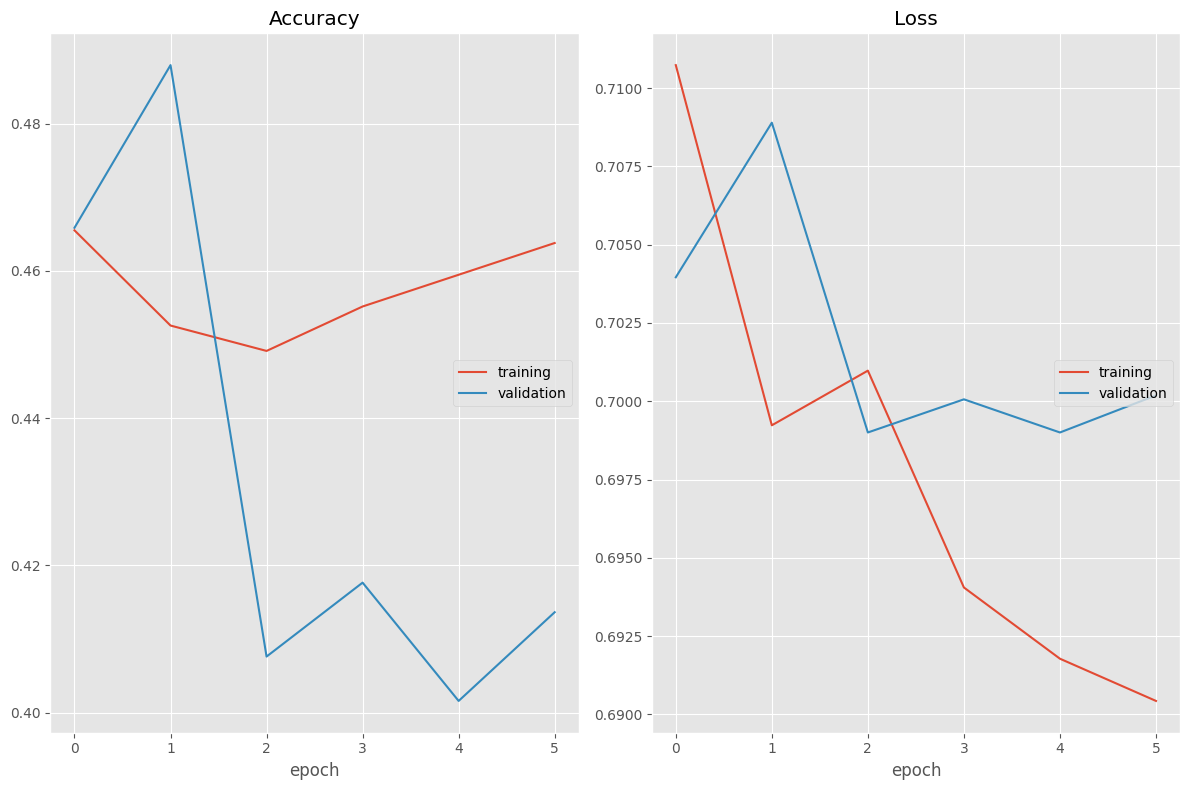
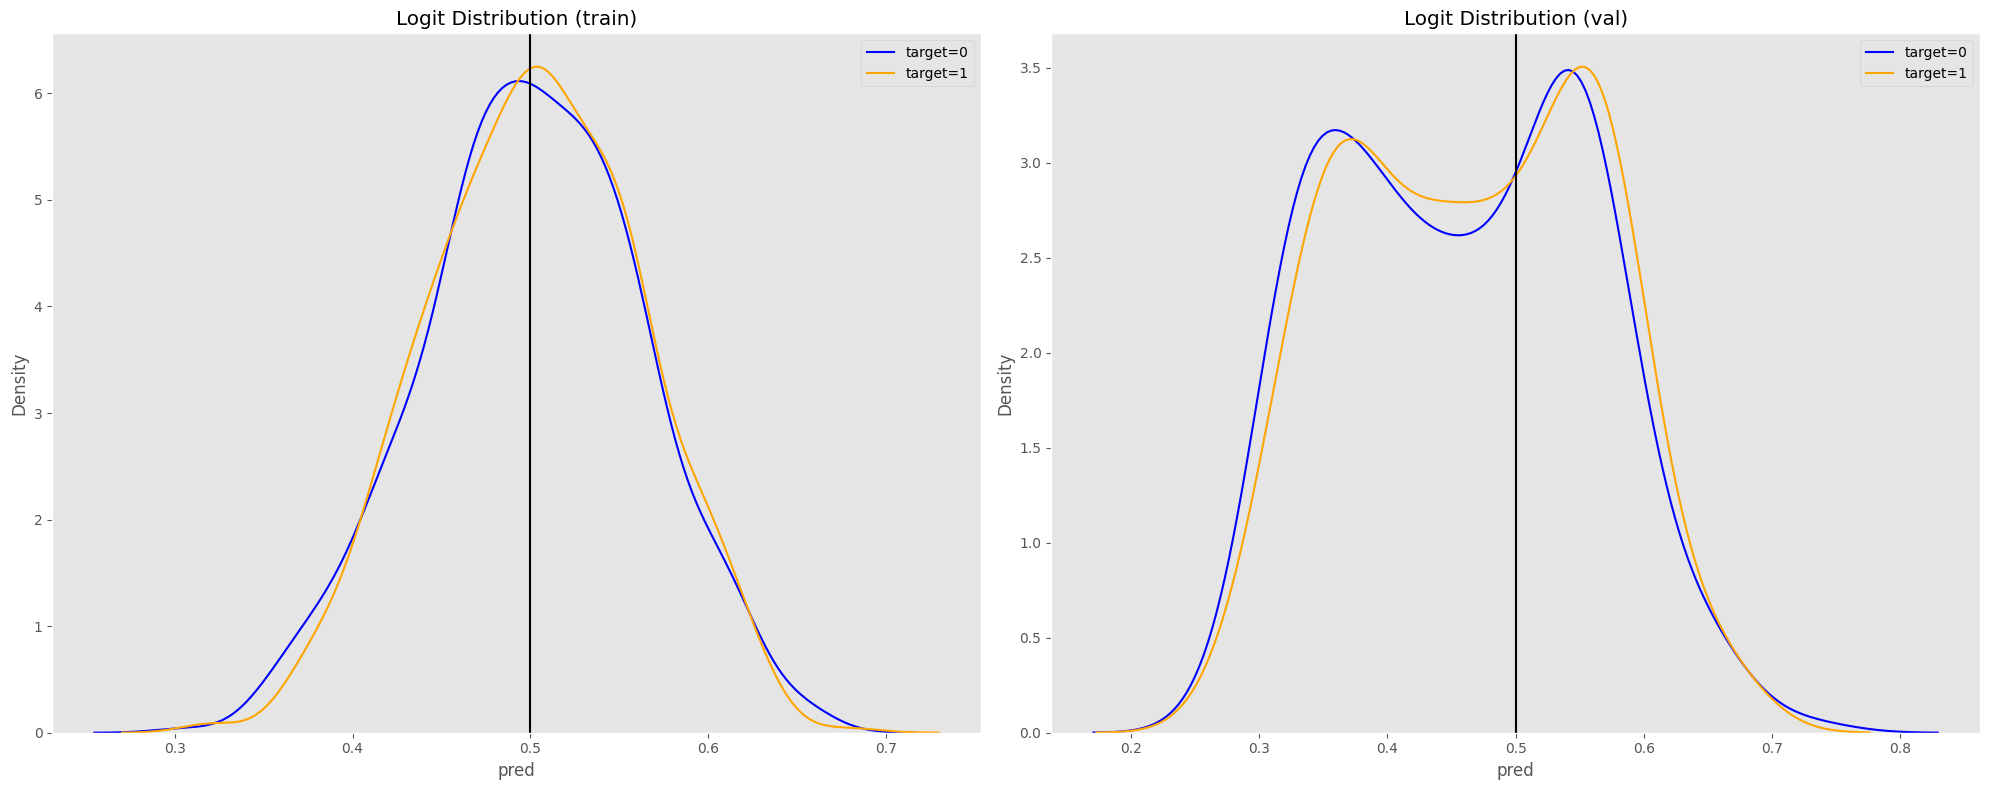
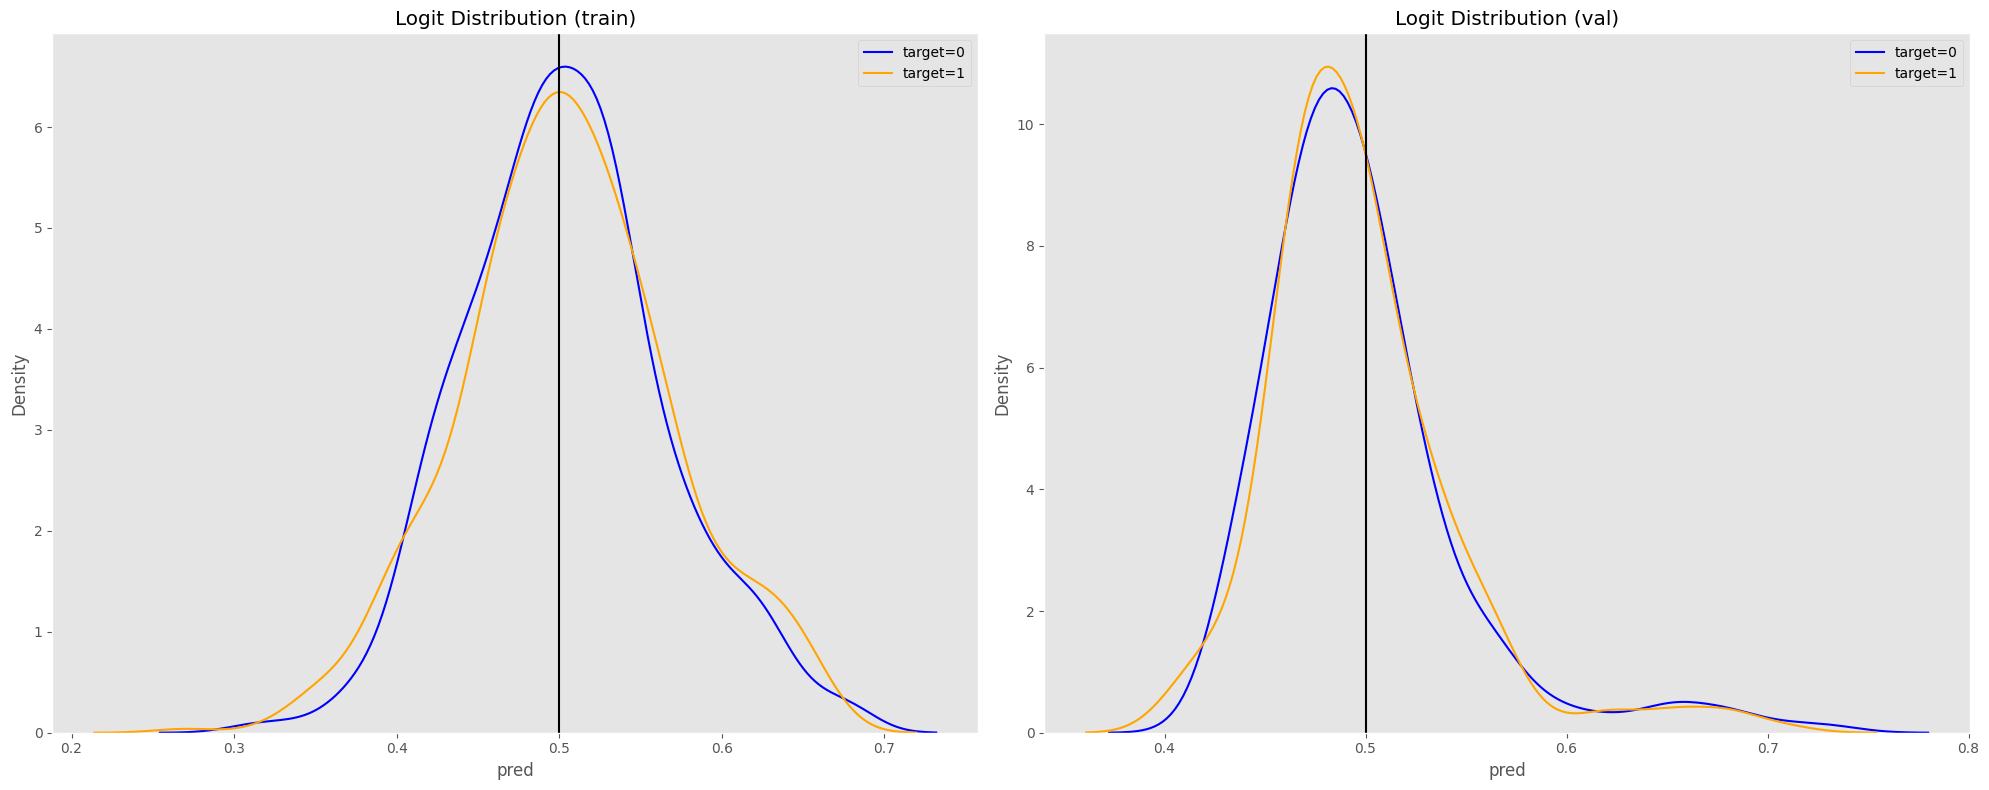
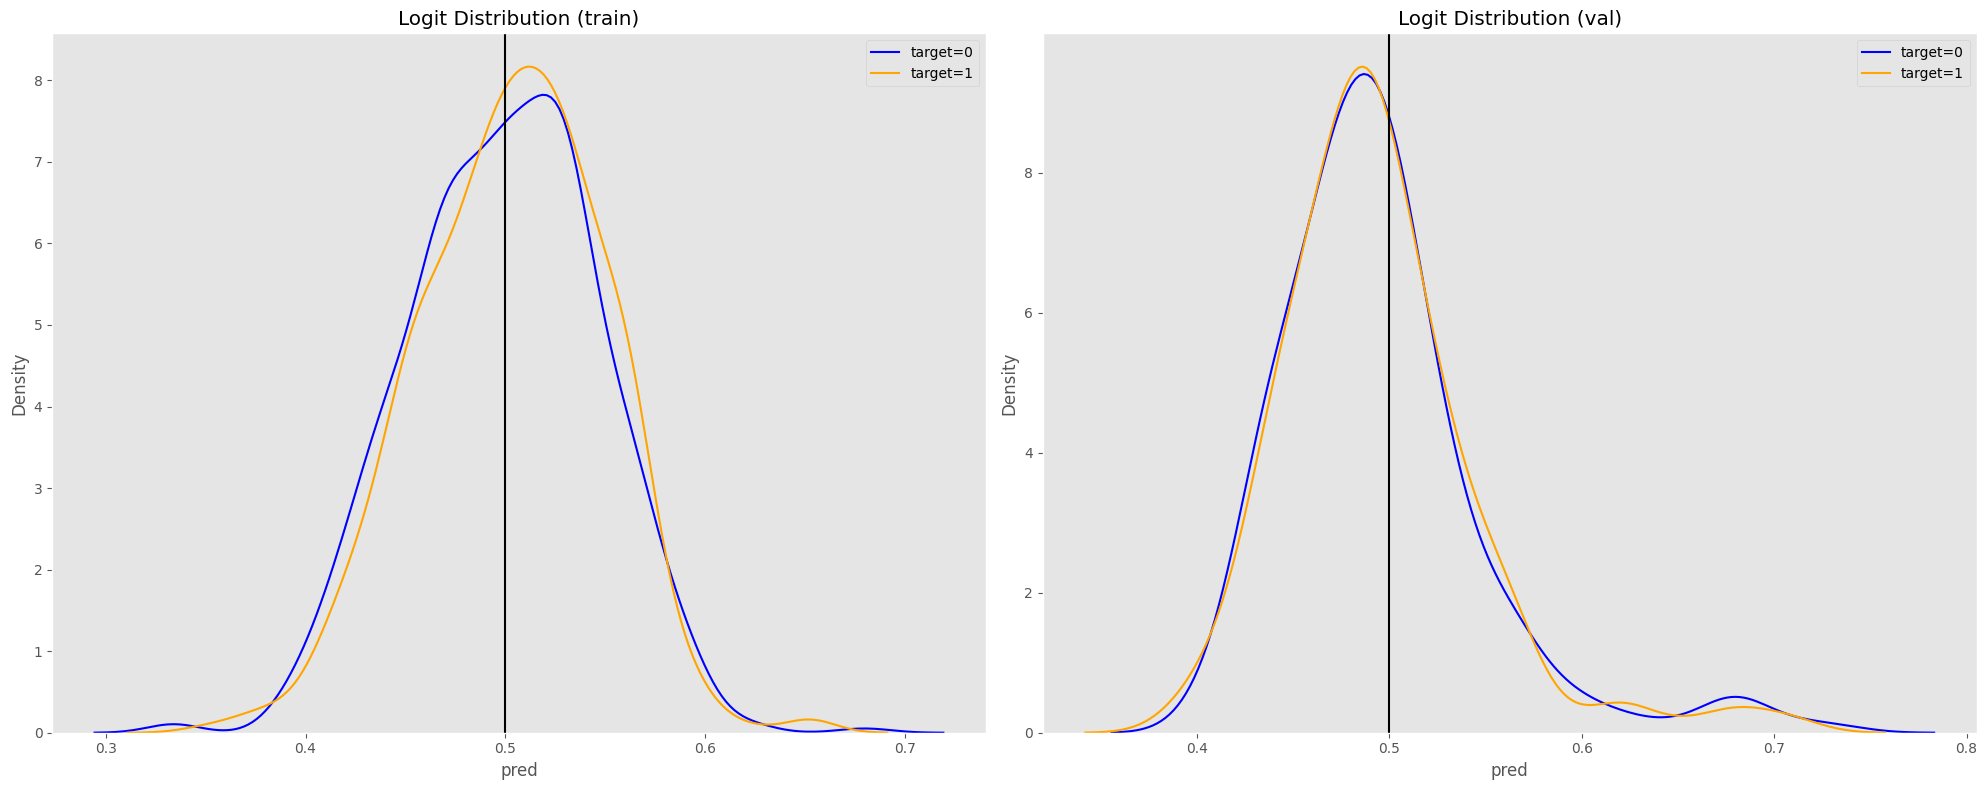
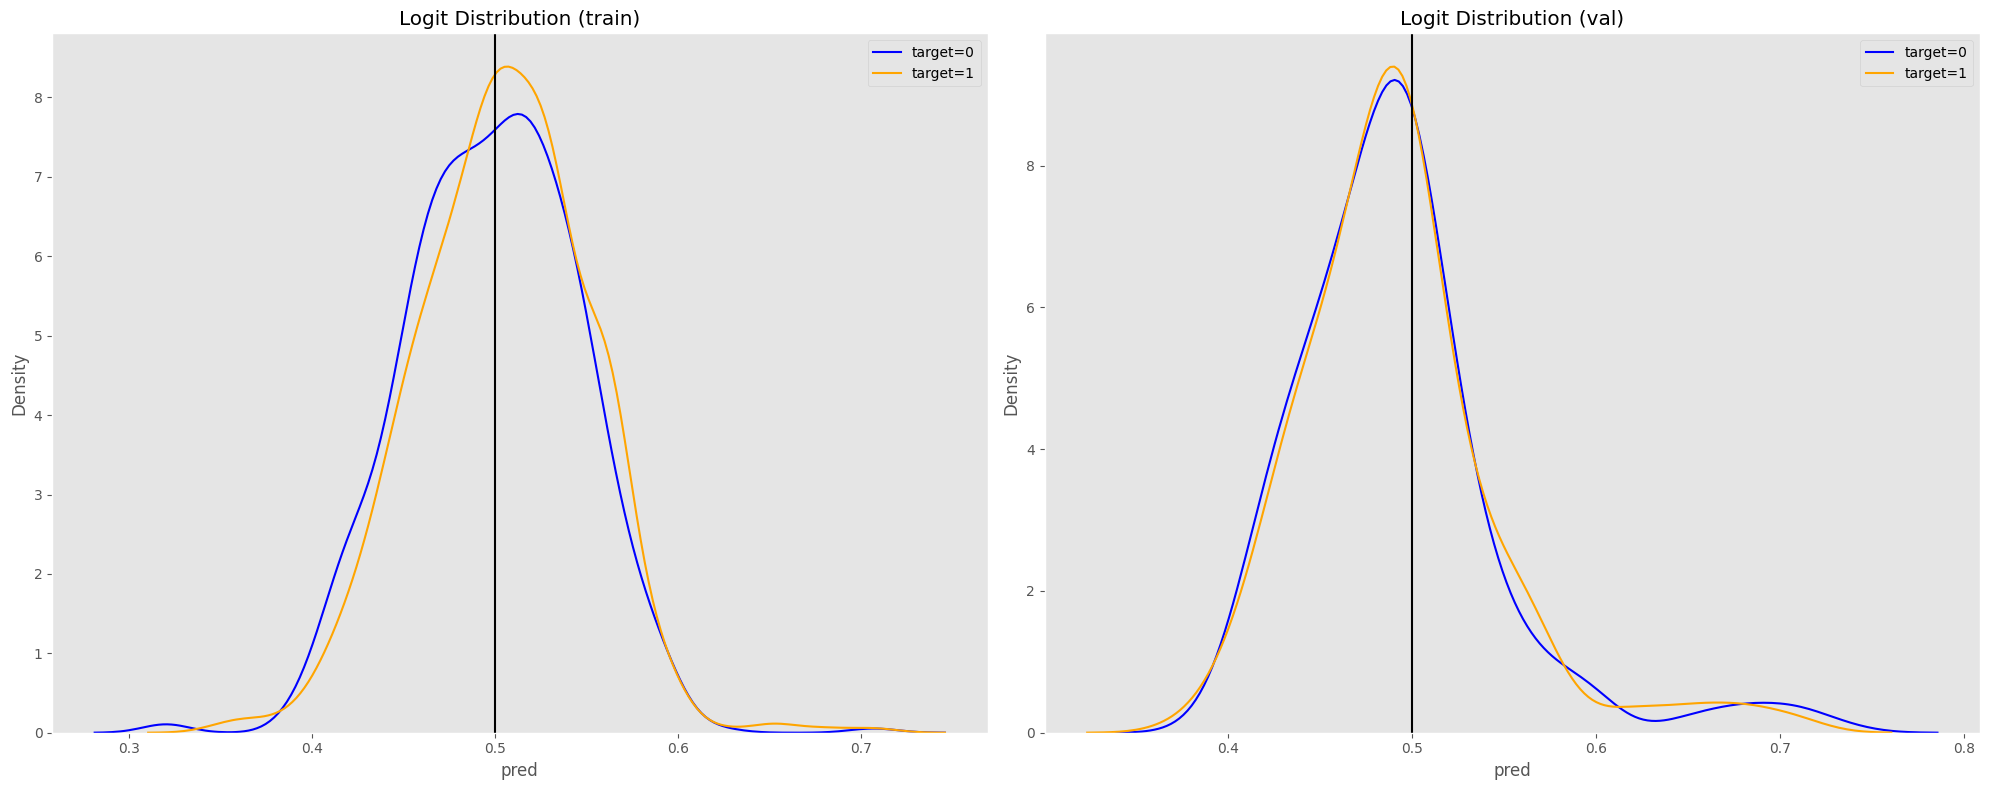
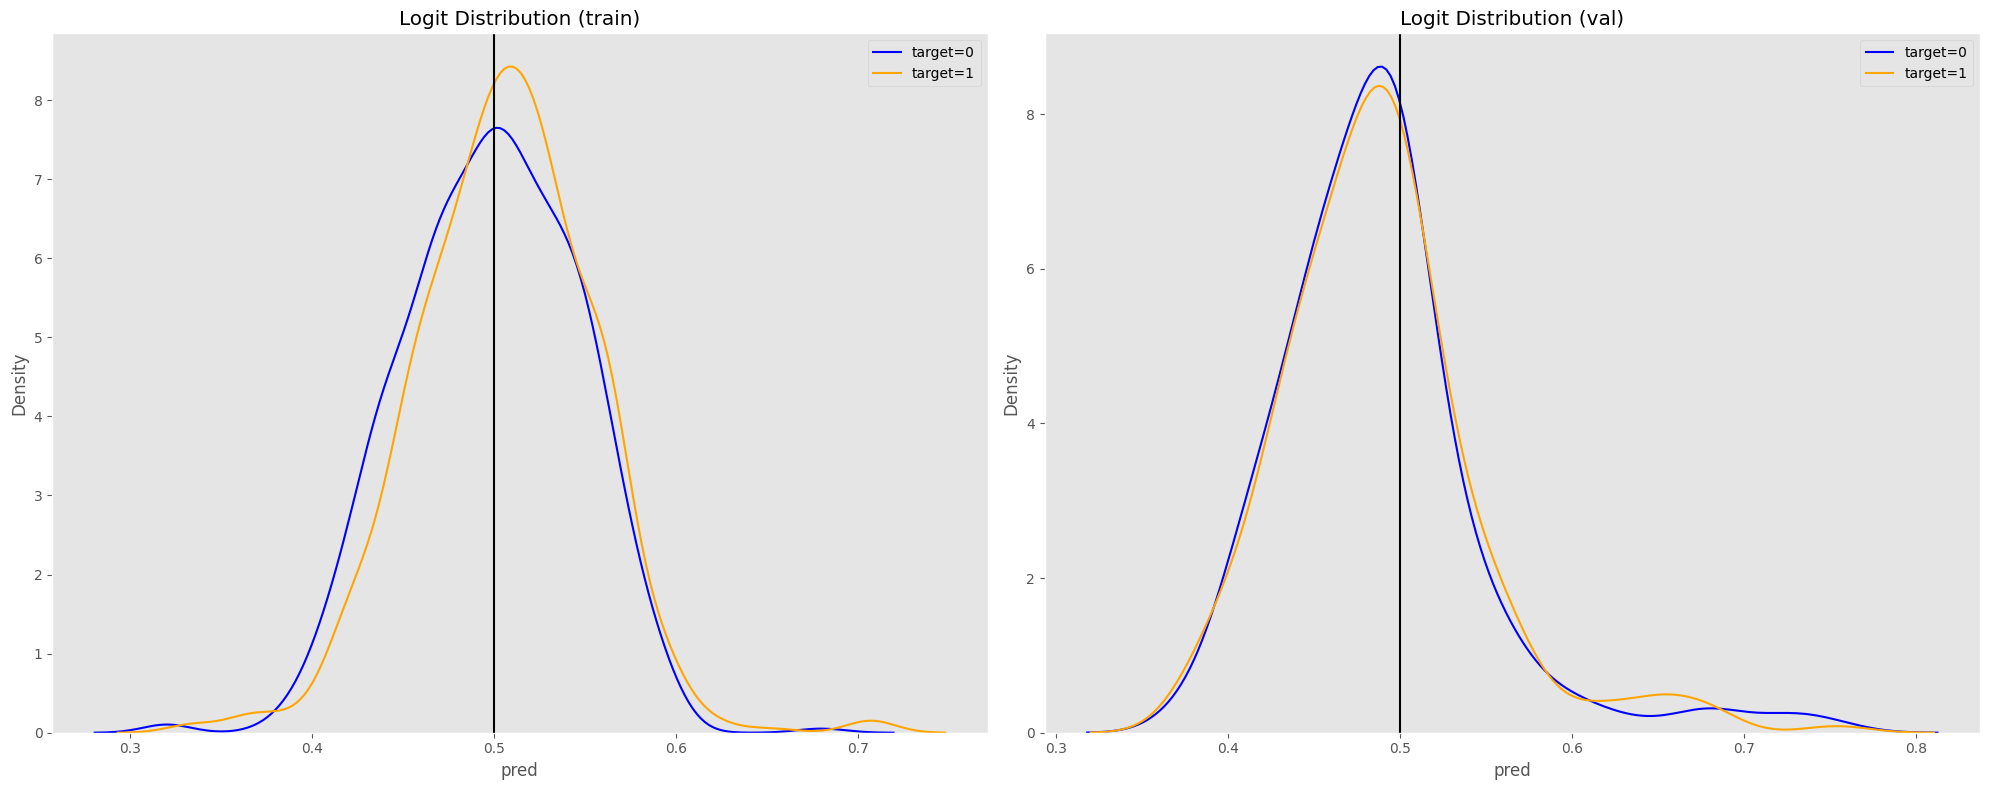

# 5. Inference

## 5.1 Load Model

In [ ]:
# model.load_state_dict(torch.load(join(PATH.models, 'lora-epoch={3}-val_loss={0.93:.2}.pt')), strict=False)

## 5.2 Inference

In [ ]:
preds = []

model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_dl):
        output     = model(X).logits       # B, S, D = output.logits.shape
        zero_logit = output[:, -1, 29900]  # [B]
        one_logit  = output[:, -1, 29896]  # [B]
        pred       = (zero_logit[0] > one_logit[0]).int()
        preds.append(pred)

sample = pd.read_csv(PATH.sample)
sample[target] = to_cpu(torch.tensor(preds)).astype(int)
sample.to_csv(join(PATH.submit, "vicuna-12b-3epoch.csv"), index=False)

---

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import re

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# 문자열 전처리
cols = ['first_party', 'second_party', 'facts']
shortword = re.compile(r'\W*\b\w{1}\b')
tokenizer = TreebankWordTokenizer()
stopword = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# 전처리 함수 1
def preprocessing(df, cols, shortword, tokenizer, stopword, lemmatizer):
    first_party_lst = []
    second_party_lst = []
    facts_lst = []
    for col in cols:
        # 좌우 공백 제거
        df[col] = df[col].str.strip()
        # 두 칸 이상의 공백 한 칸으로 변경
        df[col] = df[col].str.replace('  ', ' ')
        # 소문자로 변경
        df[col] = df[col].str.lower()
        # ",", "." 제거
        df[col] = df[col].str.replace(',','')
        df[col] = df[col].str.replace('.','')

        if col == 'first_party':
            for sample in df[col]:
                # 한글자 단어 제거
                sample = shortword.sub('', sample)
                # 특수문자 제거
                sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                # tokenzier를 이용한 단어 토큰화
                token = tokenizer.tokenize(sample)
                # 불용어 제거
                new_token = []
                for tok in token:
                    if tok not in stopword:
                        # 표제어 추출
                        new_token.append(lemmatizer.lemmatize(tok, 'n'))
                first_party_lst.append(new_token)
            # sklearn.feature_extraction 변환을 위해 단어들을 결합
            for i in range(len(first_party_lst)):
                first_party_lst[i] = ' '.join(first_party_lst[i])

        elif col == 'second_party':
            for sample in df[col]:
                # 한글자 단어 제거
                sample = shortword.sub('', sample)
                # 특수문자 제거
                sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                # tokenzier를 이용한 단어 토큰화
                token = tokenizer.tokenize(sample)
                # 불용어 제거
                new_token = []
                for tok in token:
                    if tok not in stopword:
                        # 표제어 추출
                        new_token.append(lemmatizer.lemmatize(tok, 'n'))
                second_party_lst.append(new_token)
            # sklearn.feature_extraction 변환을 위해 단어들을 결합
            for i in range(len(second_party_lst)):
                second_party_lst[i] = ' '.join(second_party_lst[i])

        elif col=='facts':
            for sample in df[col]:
                # 한글자 단어 제거
                sample = shortword.sub('', sample)
                # 특수문자 제거
                sample = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", sample)
                # tokenzier를 이용한 단어 토큰화
                token = tokenizer.tokenize(sample)
                # 불용어 제거
                new_token = []
                for tok in token:
                    if tok not in stopword:
                        new_token.append(tok)
                facts_lst.append(new_token)
            # sklearn.feature_extraction 변환을 위해 단어들을 결합
            for i in range(len(facts_lst)):
                facts_lst[i] = ' '.join(facts_lst[i])

        else:
            print('컬럼이름을 변경하지 말아주세요!')

    return first_party_lst, second_party_lst, facts_lst

# 전처리 함수 2(벡터화)
def preprocessing_2(first, second, facts, vec, vec_facts, train=True):
    if train:
        vec.fit(first + second)
        vec_facts.fit(facts)

    X1 = vec.transform(first).toarray()
    X2 = vec.transform(second).toarray()
    X3 = vec_facts.transform(facts).toarray()

    return np.concatenate([X1, X2, X3], axis=1)

In [ ]:
train_full_data = pd.read_csv(PATH.train)

In [ ]:
# 문자열 전처리 1
cols       = ['first_party', 'second_party', 'facts']
shortword  = re.compile(r'\W*\b\w{1}\b')
tokenizer  = TreebankWordTokenizer()
stopword   = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

first_train, second_train, facts_train = preprocessing(train_full_data, cols, shortword, tokenizer, stopword, lemmatizer)

# 문자열 전처리 2(벡터화)
vec       = CountVectorizer(ngram_range=(1, 2))
vec_facts = TfidfVectorizer(ngram_range=(1, 2))

X_train = preprocessing_2(first_train, second_train, facts_train, vec, vec_facts)
y_train = train_full_data[target]

# 1. imblearn

In [ ]:
X_nc, y_nc = NeighbourhoodCleaningRule(n_neighbors=3).fit_resample(X_train, y_train)
X_train_pp, X_val_pp, y_train_pp, y_val_pp = train_test_split(X_nc, y_nc, test_size=0.25, stratify=y_nc)
X_train_pp.shape, y_train_pp.shape, X_val_pp.shape, y_val_pp.shape

Logistic = LogisticRegression(max_iter=500, random_state=42)
Logistic.fit(X_train_pp, y_train_pp)
print(classification_report(y_val_pp, Logistic.predict(X_val_pp)))

In [ ]:
train_full_data_pp2 = preprocess(train_full_data, target)[['first_party_grp', 'second_party_grp', target]]

In [ ]:
X_train_pp, X_val_pp, y_train_pp, y_val_pp = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

Logistic = LogisticRegression(max_iter=500, random_state=42)
Logistic.fit(X_train, y_train)
print(classification_report(y_val_pp, Logistic.predict(X_val_pp)))

In [ ]:
train_full_data_pp = preprocess(train_full_data, target)
idxs = train_full_data_pp.index

In [ ]:
X_nc, y_nc = X_train[idxs], y_train[idxs]

In [ ]:
X_train_pp, X_val_pp, y_train_pp, y_val_pp = train_test_split(X_nc, y_nc, test_size=0.25, stratify=y_nc)
X_train_pp.shape, y_train_pp.shape, X_val_pp.shape, y_val_pp.shape

Logistic = LogisticRegression(max_iter=500, random_state=42)
Logistic.fit(X_train_pp, y_train_pp)
print(classification_report(y_val_pp, Logistic.predict(X_val_pp)))